# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

**Задача:**  
- Проверить, что эффективность обогащения рассчитана правильно. Вычислить её на обучающей выборке для признака rougher.output.recovery. Найти MAE между расчётами и значением признака.
- Проанализировать признаки, недоступные в тестовой выборке. Провести предобработку данных.
- Посмотреть, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.
- Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках.
- Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.
- Вычислить итоговую sMAPE.
- Обучить разные модели и оценить их качество кросс-валидацией. Выбрать лучшую модель и проверить её на тестовой выборке.

**Описание данных**  

**Технологический процесс**  
Rougher feed — исходное сырье  
Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant  
Xanthate **— ксантогенат (промотер, или активатор флотации);  
Sulphate — сульфат (на данном производстве сульфид натрия);  
Depressant — депрессант (силикат натрия).  
Rougher process (англ. «грубый процесс») — флотация  
Rougher tails — отвальные хвосты  
Float banks — флотационная установка  
Cleaner process — очистка  
Rougher Au — черновой концентрат золота  
Final Au — финальный концентрат золота  

**Параметры этапов**  
air amount — объём воздуха  
fluid levels — уровень жидкости  
feed size — размер гранул сырья  
feed rate — скорость подачи  

**Наименование признаков**  
[этап].[тип_параметра].[название_параметра]  
Пример: rougher.input.feed_ag  
Возможные значения для блока [этап]:  
rougher — флотация  
primary_cleaner — первичная очистка  
secondary_cleaner — вторичная очистка  
final — финальные характеристики  
Возможные значения для блока [тип_параметра]:  
input — параметры сырья  
output — параметры продукта  
state — параметры, характеризующие текущее состояние этапа  
calculation — расчётные характеристики  



## Подготовка данных

### Исходные данные

In [2]:
import pandas as pd
import warnings
from sklearn.metrics import mean_absolute_error as mae
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression


In [3]:
train = pd.read_csv ('/datasets/gold_recovery_train_new.csv')
test = pd.read_csv ('/datasets/gold_recovery_test_new.csv')
full = pd.read_csv ('/datasets/gold_recovery_full_new.csv')

In [4]:
warnings.filterwarnings('ignore')
RS = 12345

In [5]:
train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


In [6]:
test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


In [7]:
full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          13938 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14049 non-null float64
final.output.tail_sol                                 14144 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14129 non-null float64
primary_cleaner.input.depressant             

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
date                                          5290 non-null object
primary_cleaner.input.sulfate                 5286 non-null float64
primary_cleaner.input.depressant              5285 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5286 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.in

In [10]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
date                                                  19439 non-null object
final.output.concentrate_ag                           19438 non-null float64
final.output.concentrate_pb                           19438 non-null float64
final.output.concentrate_sol                          19228 non-null float64
final.output.concentrate_au                           19439 non-null float64
final.output.recovery                                 19439 non-null float64
final.output.tail_ag                                  19438 non-null float64
final.output.tail_pb                                  19338 non-null float64
final.output.tail_sol                                 19433 non-null float64
final.output.tail_au                                  19439 non-null float64
primary_cleaner.input.sulfate                         19415 non-null float64
primary_cleaner.input.depressant             

In [11]:
print(train.duplicated().sum(), test.duplicated().sum(), full.duplicated().sum())

0 0 0


**- тестовая выборка составляет 27% от полной**  
**- тип данных указан корректно**  
**- видно много пропусков в данных**  
**- явных дубликатов не обнаружено**  

### Эффективность обогащения

In [12]:
df_mae = train.dropna().reset_index() #уберем пропуски из данных для подсчета эффективности
c = df_mae['rougher.output.concentrate_au'] #доля золота после очистки
f = df_mae['rougher.input.feed_au'] # доля золота до очистки
t = df_mae['rougher.output.tail_au']# доля золота в хыостах после очистки

In [13]:
recovery = ((c*(f-t))/(f*(c-t))) * 100 #эффективность обогащения
print ((recovery<0).sum(), (recovery>100).sum()) #проверяем получившиеся данные на наличие ошибок

0 0


In [14]:
mae(df_mae['rougher.output.recovery'], recovery)

9.739730529255835e-15

**Значение MAE очень мало, поэтому можем сделать вывод о корректности расчета recovery**

### Признаки недоступные в тестовой выборке

In [15]:
set(train.columns) - set(test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

**В тестовой выборке отсутствуют данные output. Это фактически выходные данные после каждого этапа очистки и являются целевыми признаками.**

### Предобработка данных

In [16]:
# если удалять строки с пропусками, то мы потеряем ппримерно 17% данных
# это непиемлемый для нас % потерь данных
# данные индексируются по временем получения информации, соседние по времени параметры часто похожи.
# наши данные не перемешены и идут по порядку
# поэтому заполняем пропуски предыдущим значением
full=full.fillna(method='pad')
train=train.fillna(method='pad')
test=test.fillna(method='pad')

In [17]:
#выборка с целевыми признаками для тестовой выборки
test_test=test.merge(full,on=['date'],how='left')
target_test=test_test[['rougher.output.recovery','final.output.recovery']]

In [18]:
#графа дата не важна для построения наших моделей, удалим их
full=full.drop('date', axis=1)
test=test.drop('date', axis=1)
train=train.drop('date', axis=1)

## Анализ данных

### Концентрация металлов на разных стадиях очистки

In [19]:
def concentrate (au, ag, pb, title):
    concent = []
    concent=pd.DataFrame(concent)
    concent['золото'] = au
    concent['серебро'] = ag
    concent['свинец'] = pb
    plt.figure(figsize=(10,7))
    sns.boxplot(data = concent).set_title(title)
    plt.xlabel('Металл')
    plt.ylabel('Концентрация')

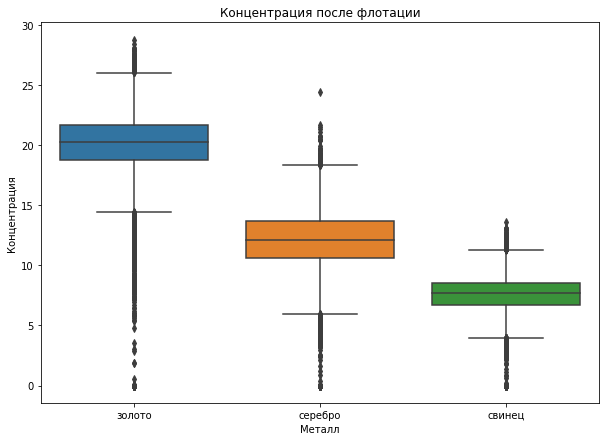

In [20]:
concentrate (full['rougher.output.concentrate_au'],
             full['rougher.output.concentrate_ag'],
             full['rougher.output.concentrate_pb'],
            'Концентрация после флотации')

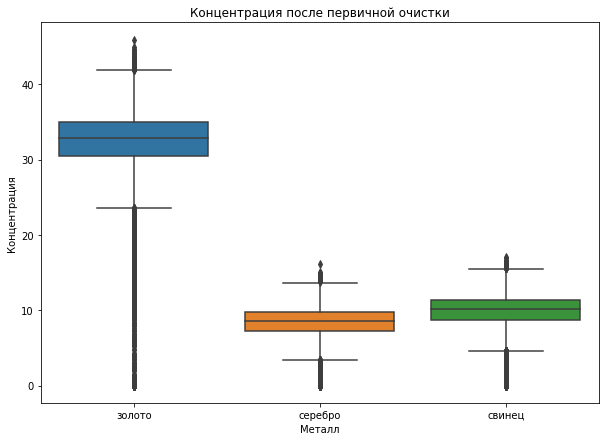

In [21]:
concentrate (full['primary_cleaner.output.concentrate_au'],
             full['primary_cleaner.output.concentrate_ag'],
             full['primary_cleaner.output.concentrate_pb'],
            'Концентрация после первичной очистки')

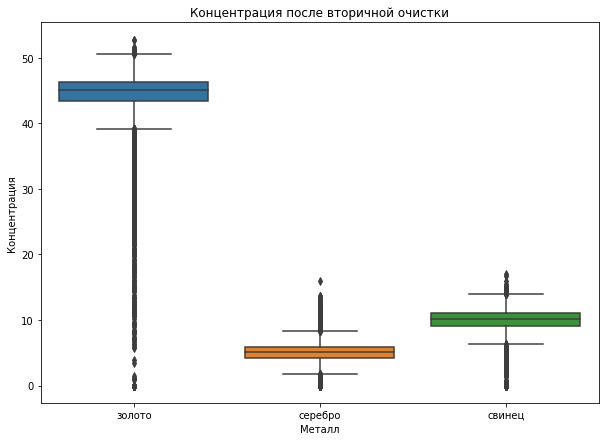

In [22]:
concentrate (full['final.output.concentrate_au'],
             full['final.output.concentrate_ag'],
             full['final.output.concentrate_pb'],
            'Концентрация после вторичной очистки')

In [23]:
def concentrate_hist(metal, title):
    roughter = full[f'rougher.output.concentrate_{metal}']
    primary = full[f'primary_cleaner.output.concentrate_{metal}']
    final = full[f'final.output.concentrate_{metal}']
    plt.figure(figsize=(10, 7))
    sns.distplot(roughter, kde_kws= {"label": "флотация"})
    sns.distplot(primary, kde_kws= {"label": "первичная очистка"})
    sns.distplot(final, kde_kws= {"label": "вторичная очистка"})
    plt.title(label=f'Концентрация {title} на различных этапах очистки')
    plt.xlabel('Концентрация')
    plt.ylabel('Количество наблюдений')

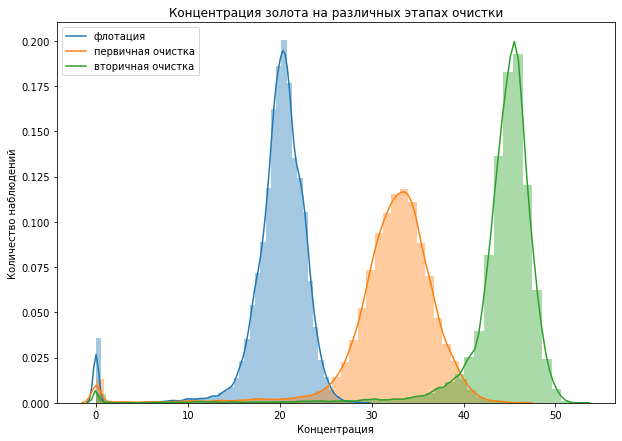

In [24]:
concentrate_hist('au', 'золота')

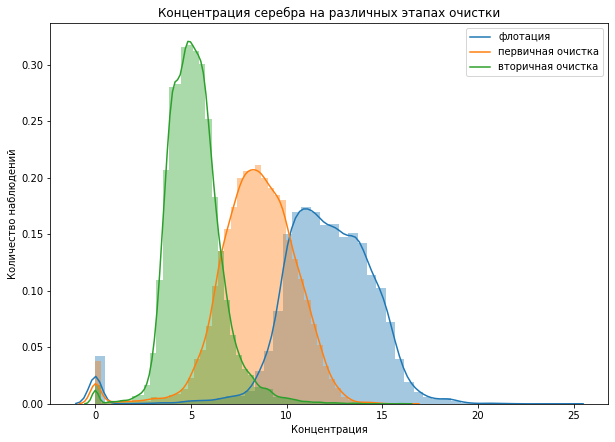

In [25]:
concentrate_hist('ag', 'серебра')

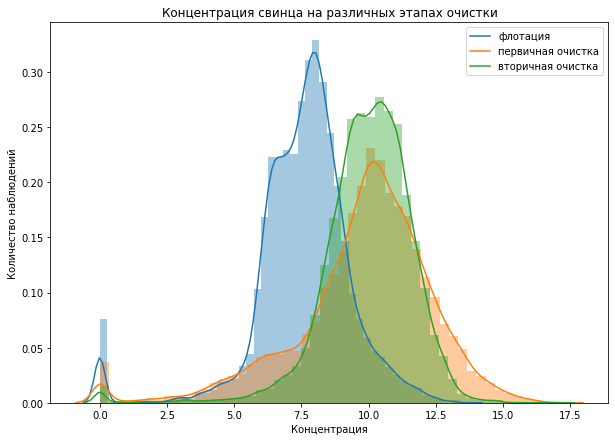

In [26]:
concentrate_hist('pb', 'свинца')

**- имеется большое количество выбросов всех 3 металлов на всех стадиях очистки**  
**- концентрация золота с каждой новой стадией увеличивается, серебра - снижается**  
**- концентрация свинца после 1-ой очистки немного увеличивается и до конца остается практически неизменной**

### Распределения размеров гранул сырья

In [27]:
def size (stage, title):
    size_train = train[f'{stage}.input.feed_size']
    size_test = test[f'{stage}.input.feed_size']
    plt.figure(figsize=(10, 7))
    sns.distplot(size_train, kde_kws= {"label": "Обучающая выборка"})
    sns.distplot(size_test, kde_kws= {"label": "Тестовая выборка"})
    plt.xlabel('Размер гранул')
    plt.ylabel('Количество наблюдений')
    plt.title(label=f'Распределение размеров гранул сырья для {title}')
    print(f'Средний размер гранул в обучающей выборке для {title} {round(size_train.mean(), 2)}')
    print(f'Средний размер гранул в тестовой выборке для {title} {round(size_test.mean(), 2)}')

Средний размер гранул в обучающей выборке для флотации 60.24
Средний размер гранул в тестовой выборке для флотации 55.95


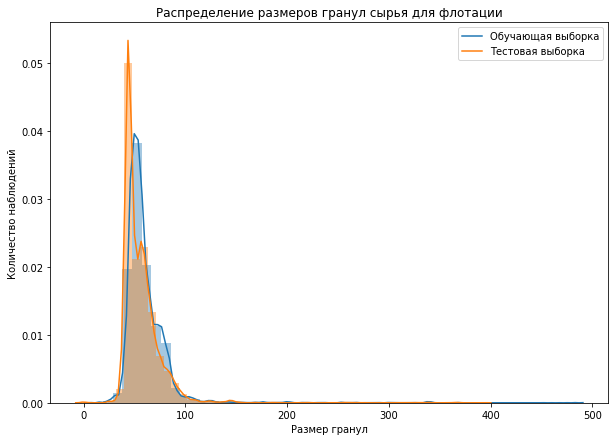

In [28]:
size ('rougher', 'флотации')

Средний размер гранул в обучающей выборке для первичной очистки 7.32
Средний размер гранул в тестовой выборке для первичной очистки 7.27


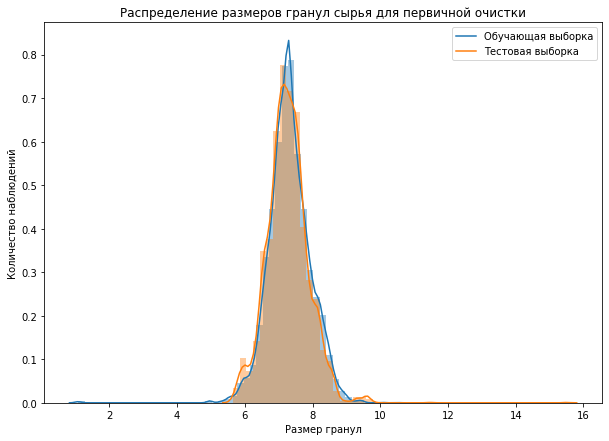

In [29]:
size ('primary_cleaner', 'первичной очистки')

**- распределения размеров гранул сырья на обучающей и тестовой выборках на этапе флотации отличаются**  
**- это может быть связано с разницей в размерах выборок**  
**- средние при этом различаются незначительно (погрешность порядка 7%)**  
**- при первичной очистки, распределения очень даже похожи, средние практически не отличаются**  
**- следовательно можно говорить ,что распределения тестовой и обучающей выборок не отличаются**

### Суммарная концентрация всех веществ на разных стадиях

In [30]:
#Исследуйем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.
stage = ['rougher.input.feed_',
         'rougher.output.concentrate_', 
         'final.output.concentrate_']
for i in stage:
    train[i] = train[i + 'au'] + train[i + 'ag'] + train[i + 'pb'] + train[i + 'sol']

Text(0.5, 1.0, 'Суммарная концентрация всех веществ на разных стадиях')

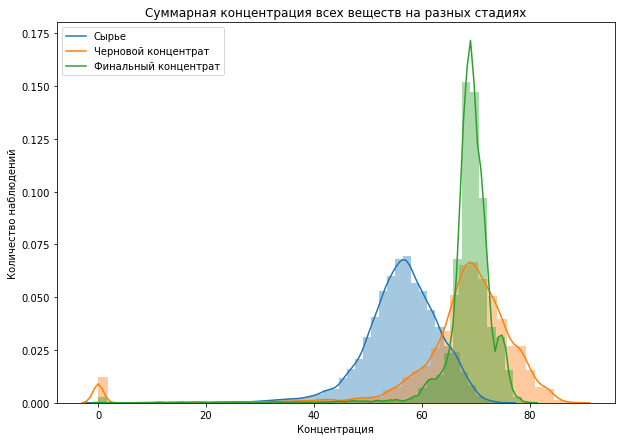

In [31]:
plt.figure(figsize=(10, 7))
sns.distplot(train['rougher.input.feed_'], kde_kws= {"label": "Сырье"})
sns.distplot(train['rougher.output.concentrate_'], kde_kws= {"label": "Черновой концентрат"})
sns.distplot(train['final.output.concentrate_'], kde_kws= {"label": "Финальный концентрат"})
plt.xlabel('Концентрация')
plt.ylabel('Количество наблюдений')
plt.title(label='Суммарная концентрация всех веществ на разных стадиях')

In [32]:
train_new = train[(train['rougher.input.feed_'] > 40)
                  & (train['rougher.output.concentrate_'] > 50)
                  & (train['final.output.concentrate_'] > 60)]

**- концентрация веществ растет вместе со сменой стадий**  
**- по распределению видно, что присутствуют выбросы**  
**- есть много значений с концентрацией веществ менее 40-60**  
**- их достаточно много (около 8,5%), при этом частота их повторения стремиться к нулю**  
**- удалим их из обучающей выборки, чтобы не мешали обучению модели**  
**- из тестовой модели данные значения удалять не будем, для более репрезентативного теста**

## Модель

### sMAPE

In [33]:
#целевые признаки - эффективность обогащения чернового концентрата и эффективность обогащения финального концентрата

In [34]:
features = train_new[test.columns] #колонки из тестовой выборки
targets=train_new[['rougher.output.recovery','final.output.recovery']] # Формируем выборку целевых признаков

In [35]:
#проведем стандартизацию данных
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)
features = pd.DataFrame (features) #первеодим в DF для расчета 2-го варианта кросс-валидации через iloc
test = scaler.transform(test)

In [36]:
# Функция sMAPE
def smape(target, predict):
    predict_rougher=predict[:,0]
    target_rougher=target[:,0]
    predict_final=predict[:,1]
    target_final=target[:,1]
    smape_rougher = (1/len(predict_rougher))*np.sum(np.abs(target_rougher - predict_rougher)
                                                    /((np.abs(target_rougher)+np.abs(predict_rougher))/2)) * 100
    smape_final = (1/len(predict_final))*np.sum(np.abs(target_final - predict_final)
                                                /((np.abs(target_final)+np.abs(predict_final))/2)) * 100
    return 0.25*smape_rougher+0.75*smape_final

### Модели

#### Линейная регрессия

In [37]:
model_line = LinearRegression()
model_line.fit (features, targets)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [40]:
%%time
score = make_scorer(smape)
                    #, greater_is_better=False)
scores_line = cross_val_score(model_line, features, targets.values, cv=5, scoring=score)
print('sMAPE при кросс-валидации', round(scores_line.mean(), 3))

sMAPE при кросс-валидации 9.38
CPU times: user 588 ms, sys: 709 ms, total: 1.3 s
Wall time: 1.15 s


#### Дерево решений

In [546]:
%%time
n = 1000
max_depth = 0
for depth in range(1,5,1):
    model_tree = DecisionTreeRegressor(max_depth = depth, random_state = RS)
    score_tree = cross_val_score(model_tree, features, targets.values, cv=5, scoring=score).mean()
    if score_tree < n:
        n = score_tree
        max_depth = depth
print ('Глубина дерева', max_depth, 'sMAPE', round(n, 3))

Глубина дерева 2 sMAPE 8.386
CPU times: user 3.56 s, sys: 71.4 ms, total: 3.63 s
Wall time: 3.65 s


#### Случайный лес

In [547]:
%%time
n = 1000
max_depth = 0
forest = 0
for estim in range(5,10,1):
    for depth in range(2,3,1):
        model_forest = RandomForestRegressor(max_depth = depth, n_estimators = estim, random_state = RS)
        score_forest = cross_val_score(model_forest, features, targets.values, cv=5, scoring = score).mean()
        if score_forest < n:
            n = score_forest
            max_depth = depth
            forest = estim
print ('Количество деревьев', forest ,'Глубина дерева', max_depth, 'sMAPE', round(n, 3))

Количество деревьев 6 Глубина дерева 2 sMAPE 8.215
CPU times: user 15.9 s, sys: 199 ms, total: 16.1 s
Wall time: 16.1 s


**Наилучший результат sMAPE у модели "Случайные лес" с количеством деревьев 6 и глубиной дерева 2. sMAPE = 8.215**

#### Проверка лучшей модели на тестовой выборке

In [548]:
model_test = RandomForestRegressor(max_depth = 2, n_estimators = 6, random_state = RS)
model_test.fit(features, targets)
prediction_test = model_test.predict(test)
smape_test = smape(target_test.values, prediction_test)
print ('sMAPE тестовой модели', round(smape_test, 3))

sMAPE тестовой модели 9.26


**- Наилучший результат sMAPE у модели "Случайный лес - 8.215**  
**- На тестовой выборке данная модель показала результат хуже - 9.26**  
**- Остальные модели показывали разницу с тестовой выборкой еще в большем размере**    
**- Это может быть связано с размером выборки, аномальными значениями в тесте и изменением гиперпараметров модели**  
**- При наличии вычислительных мощностей можно сделать балансировку данных и перебрать различные гиперпараметры**  
**- Аномальные значения из теста я бы не убирал, так как это будет фактически подгонка под результат**  
**- Если не убирать аномальные значения из обучающей выборки - значения sMAPE у моделей вырастит, но будет ближе к результатам тестовой модели**  
**- Но в данном случае неизвестно как модель будет себя вести на большей выборке с большим количеством выбросов**